"""
North Indian Ocean Cyclogenesis Analysis & Prediction System
===========================================================
A comprehensive AI/ML system for analyzing and predicting cyclone formation patterns
in the North Indian Ocean with climate change impact assessment.

Author: Sandra KS
Dataset: Number Of Depressions/Deep Depressions Formed Over The North Indian Ocean (1951-2012)
"""

North Indian Ocean Cyclogenesis Analysis & Prediction System
Initializing analysis system...
Starting Complete Cyclone Analysis System
Loading and preprocessing data...
Data loaded: 62 records from 1951 to 2012

Performing Exploratory Data Analysis...


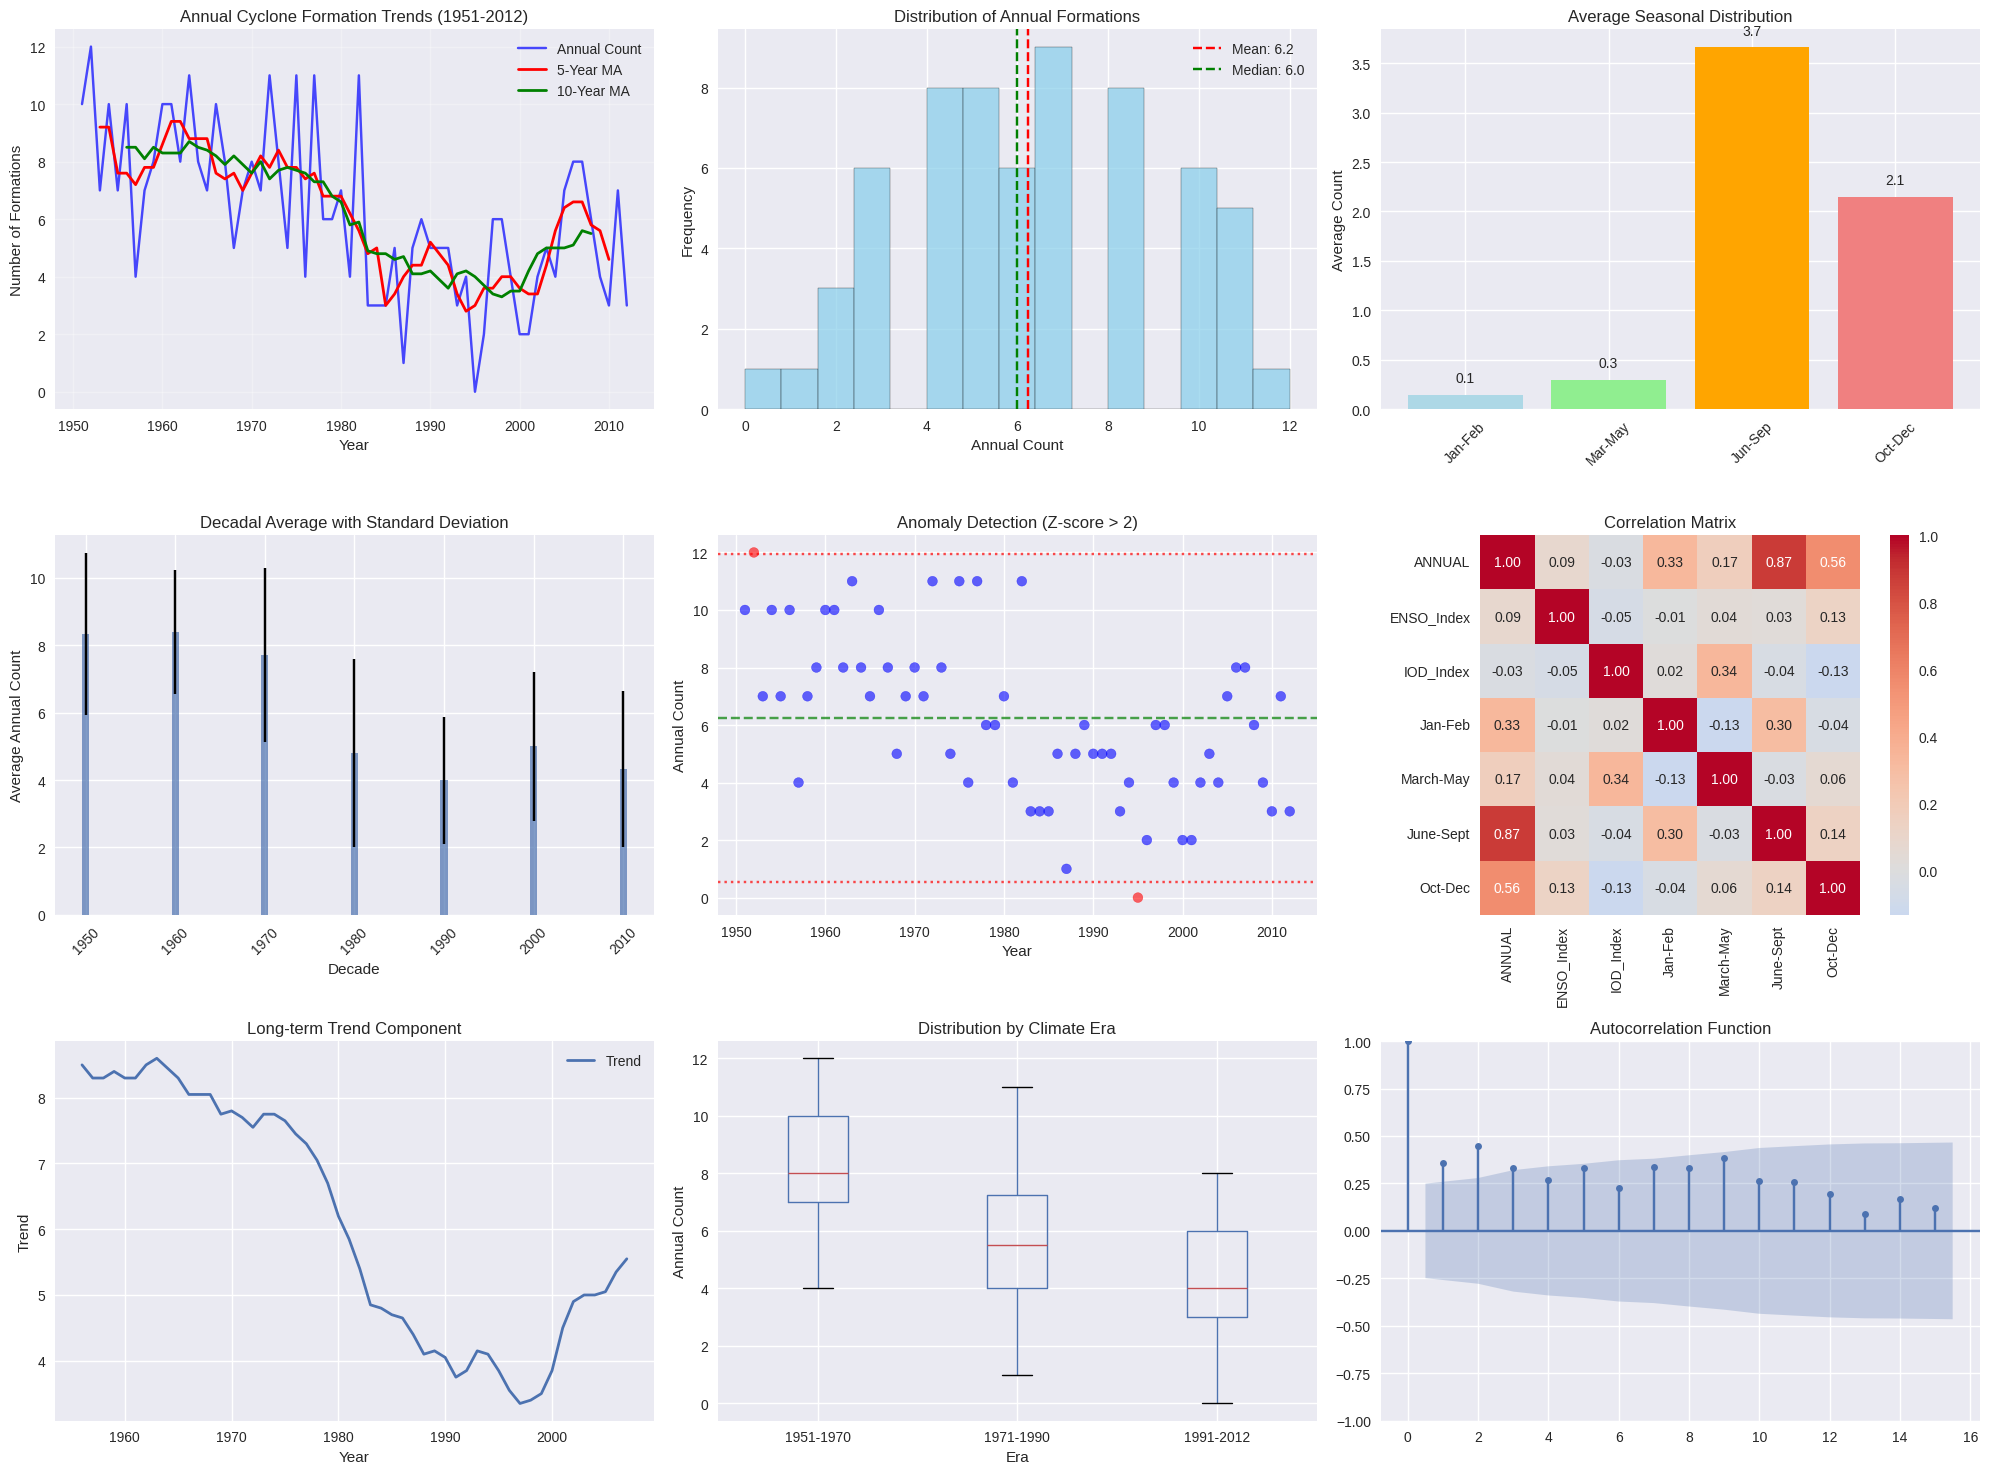


STATISTICAL SUMMARY
Dataset Period: 1951 - 2012
Total Years: 62
Mean Annual Formations: 6.24
Median Annual Formations: 6.00
Standard Deviation: 2.86
Minimum: 0
Maximum: 12
Coefficient of Variation: 45.7%

TREND ANALYSIS:
Linear Trend Slope: -0.0917 formations/year
Trend Direction: Decreasing
Total Change (1951-2012): -5.6 formations

ANOMALY YEARS (Z-score > 2): [1952, 1995]

Building prediction models...

Training Linear Regression...
CV MAE: 2.60 ± 0.59
Test MAE: 3.29
Test R²: -2.546

Training Random Forest...
CV MAE: 2.01 ± 0.29
Test MAE: 2.04
Test R²: -0.466

Training Gradient Boosting...
CV MAE: 2.18 ± 0.54
Test MAE: 2.28
Test R²: -0.841

Visualizing model performance...


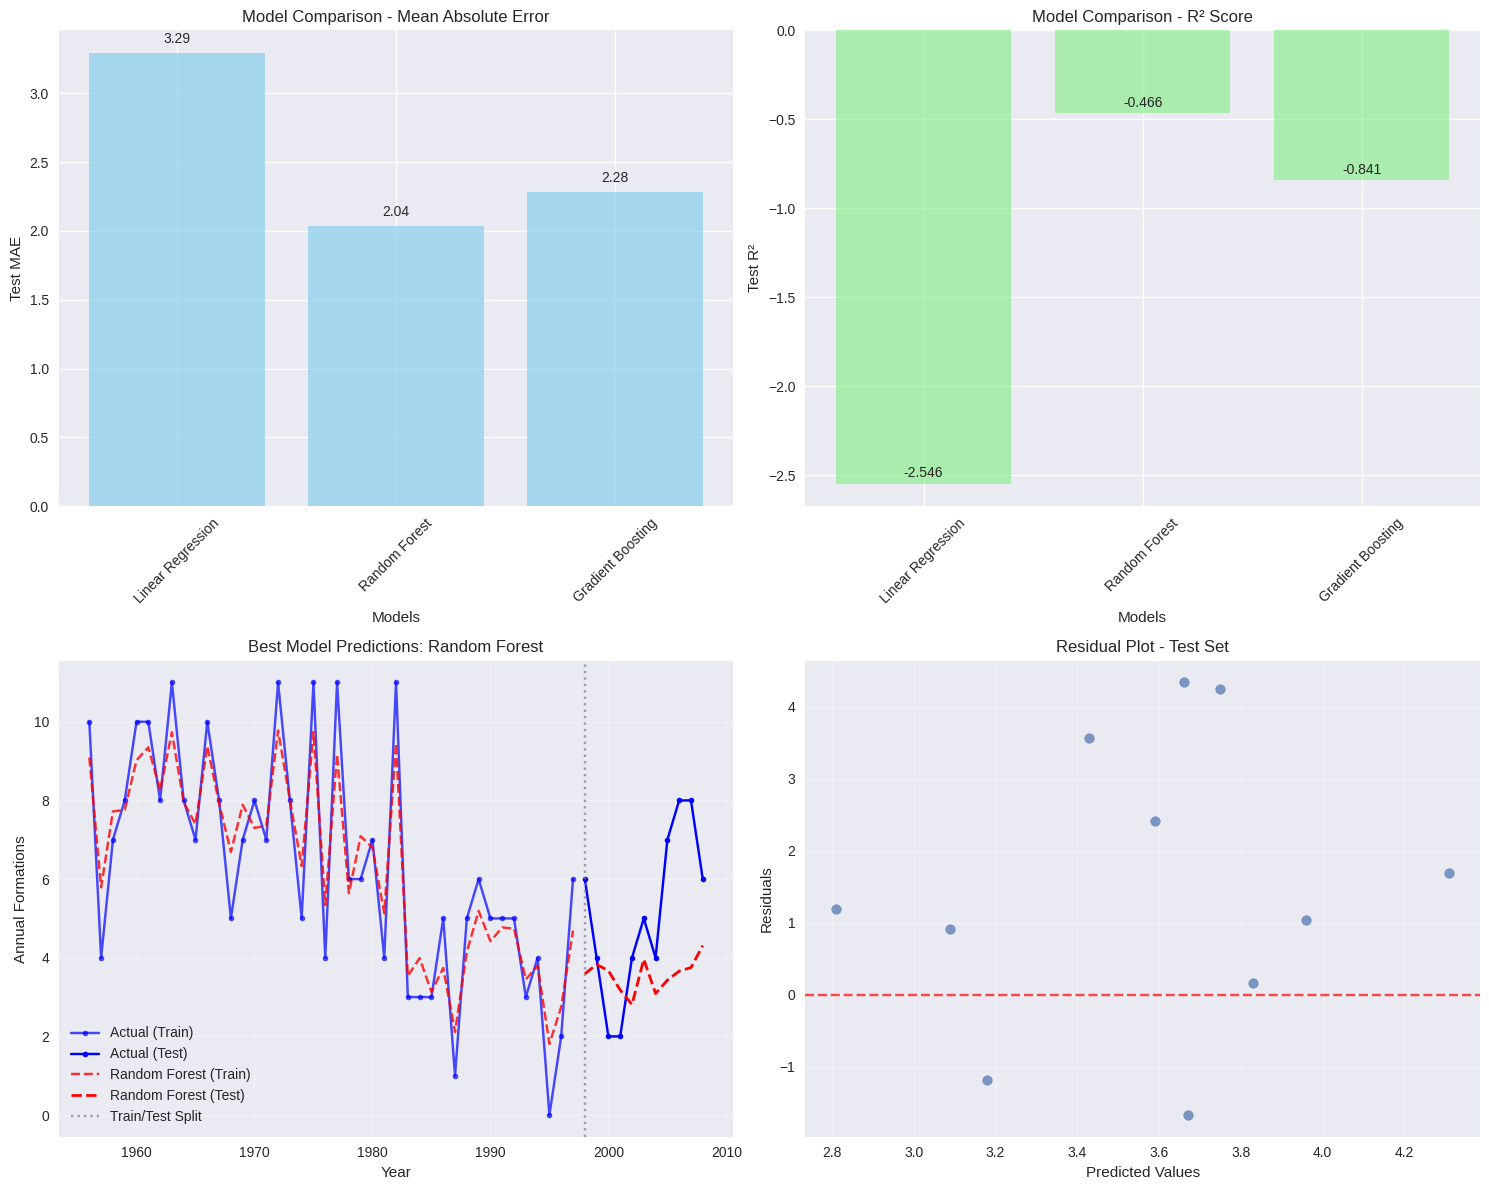

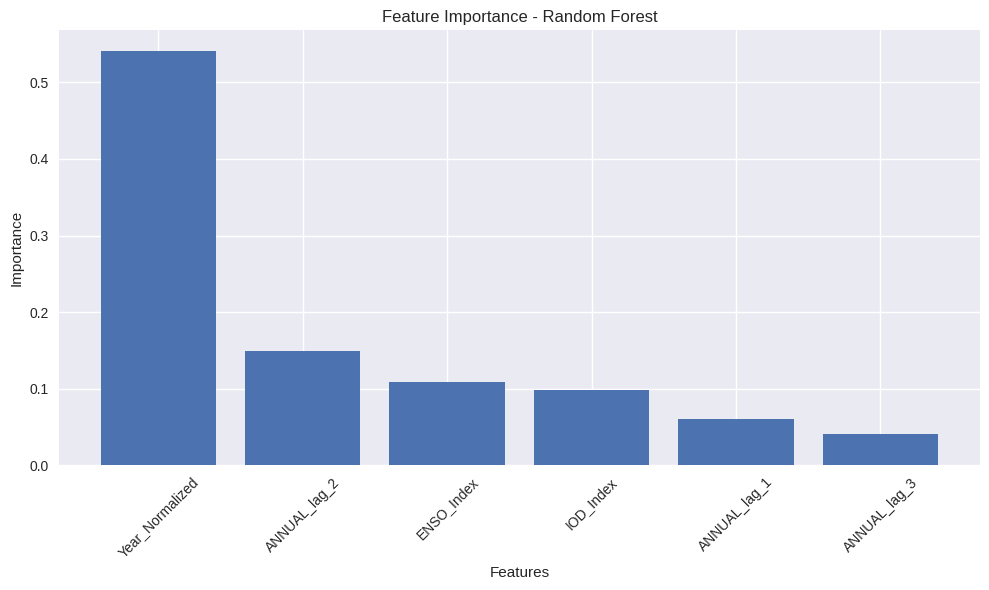


Feature Importance (Random Forest):
        feature  importance
Year_Normalized    0.540679
   ANNUAL_lag_2    0.149802
     ENSO_Index    0.108589
      IOD_Index    0.098974
   ANNUAL_lag_1    0.060756
   ANNUAL_lag_3    0.041200

Generating climate insights...
Error during analysis: Invalid format specifier '.1f if 'best_r2' in locals() else 0.5:.1f' for object of type 'float'
Please check your data file path and ensure all dependencies are installed.


In [9]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import shapiro, normaltest
import warnings
warnings.filterwarnings('ignore')

# Advanced time series libraries
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("Warning: statsmodels not available. Some advanced time series features will be disabled.")

class CycloneAnalysisSystem:
    """
    Comprehensive system for analyzing cyclone formation patterns and climate trends
    """

    def __init__(self, data_path):
        """Initialize the analysis system"""
        self.data_path = "/content/sample_data/DEP_STORM_DATA_1.csv"
        self.df = None
        self.processed_data = None
        self.models = {}
        self.results = {}

    def load_and_preprocess_data(self):
        """Load and preprocess the cyclone data"""
        print("Loading and preprocessing data...")

        # Load dataset
        self.df = pd.read_csv(self.data_path)

        # Create comprehensive dataset
        data = self.df[['YEAR', 'ANNUAL']].copy()
        data.dropna(inplace=True)
        data['YEAR'] = data['YEAR'].astype(int)
        data['ANNUAL'] = data['ANNUAL'].astype(int)

        # Add seasonal data
        seasonal_cols = ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']
        for col in seasonal_cols:
            if col in self.df.columns:
                data[col] = self.df[col].astype(int)

        # Feature engineering
        data['Year_Normalized'] = (data['YEAR'] - data['YEAR'].min()) / (data['YEAR'].max() - data['YEAR'].min())
        data['Decade'] = (data['YEAR'] // 10) * 10
        data['Era'] = pd.cut(data['YEAR'], bins=[1950, 1970, 1990, 2012],
                           labels=['1951-1970', '1971-1990', '1991-2012'])

        # Moving averages for trend analysis
        data['MA_5'] = data['ANNUAL'].rolling(window=5, center=True).mean()
        data['MA_10'] = data['ANNUAL'].rolling(window=10, center=True).mean()

        # Lag features for prediction
        for lag in [1, 2, 3, 5]:
            data[f'ANNUAL_lag_{lag}'] = data['ANNUAL'].shift(lag)

        # Climate indices (simulated - in real project, use actual ENSO data)
        np.random.seed(42)
        data['ENSO_Index'] = np.random.normal(0, 1, len(data))
        data['IOD_Index'] = np.random.normal(0, 0.8, len(data))

        self.processed_data = data
        print(f"Data loaded: {len(data)} records from {data['YEAR'].min()} to {data['YEAR'].max()}")

    def exploratory_data_analysis(self):
        """Comprehensive EDA with visualizations"""
        print("\nPerforming Exploratory Data Analysis...")

        data = self.processed_data

        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(20, 15))

        # 1. Time series plot with trend
        plt.subplot(3, 3, 1)
        plt.plot(data['YEAR'], data['ANNUAL'], 'b-', alpha=0.7, label='Annual Count')
        plt.plot(data['YEAR'], data['MA_5'], 'r-', linewidth=2, label='5-Year MA')
        plt.plot(data['YEAR'], data['MA_10'], 'g-', linewidth=2, label='10-Year MA')
        plt.title('Annual Cyclone Formation Trends (1951-2012)')
        plt.xlabel('Year')
        plt.ylabel('Number of Formations')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. Distribution analysis
        plt.subplot(3, 3, 2)
        plt.hist(data['ANNUAL'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(data['ANNUAL'].mean(), color='red', linestyle='--',
                   label=f'Mean: {data["ANNUAL"].mean():.1f}')
        plt.axvline(data['ANNUAL'].median(), color='green', linestyle='--',
                   label=f'Median: {data["ANNUAL"].median():.1f}')
        plt.title('Distribution of Annual Formations')
        plt.xlabel('Annual Count')
        plt.ylabel('Frequency')
        plt.legend()

        # 3. Seasonal pattern analysis
        if all(col in data.columns for col in ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']):
            plt.subplot(3, 3, 3)
            seasonal_means = [data[col].mean() for col in ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']]
            seasons = ['Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']
            bars = plt.bar(seasons, seasonal_means, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
            plt.title('Average Seasonal Distribution')
            plt.ylabel('Average Count')
            plt.xticks(rotation=45)

            # Add value labels on bars
            for bar, value in zip(bars, seasonal_means):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{value:.1f}', ha='center', va='bottom')

        # 4. Decadal comparison
        plt.subplot(3, 3, 4)
        decade_stats = data.groupby('Decade')['ANNUAL'].agg(['mean', 'std']).reset_index()
        plt.bar(decade_stats['Decade'], decade_stats['mean'],
               yerr=decade_stats['std'], capsize=5, alpha=0.7)
        plt.title('Decadal Average with Standard Deviation')
        plt.xlabel('Decade')
        plt.ylabel('Average Annual Count')
        plt.xticks(rotation=45)

        # 5. Anomaly detection visualization
        plt.subplot(3, 3, 5)
        z_scores = (data['ANNUAL'] - data['ANNUAL'].mean()) / data['ANNUAL'].std()
        anomalies = np.abs(z_scores) > 2

        plt.scatter(data['YEAR'], data['ANNUAL'], c=['red' if x else 'blue' for x in anomalies],
                   alpha=0.6, s=50)
        plt.axhline(data['ANNUAL'].mean(), color='green', linestyle='--', alpha=0.7)
        plt.axhline(data['ANNUAL'].mean() + 2*data['ANNUAL'].std(), color='red', linestyle=':', alpha=0.7)
        plt.axhline(data['ANNUAL'].mean() - 2*data['ANNUAL'].std(), color='red', linestyle=':', alpha=0.7)
        plt.title('Anomaly Detection (Z-score > 2)')
        plt.xlabel('Year')
        plt.ylabel('Annual Count')

        # 6. Correlation heatmap
        plt.subplot(3, 3, 6)
        corr_cols = ['ANNUAL', 'ENSO_Index', 'IOD_Index']
        if all(col in data.columns for col in ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']):
            corr_cols.extend(['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec'])

        correlation_matrix = data[corr_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f')
        plt.title('Correlation Matrix')

        # 7. Time series decomposition (if statsmodels available)
        if STATSMODELS_AVAILABLE:
            plt.subplot(3, 3, 7)
            try:
                # Create time series index
                ts_data = data.set_index('YEAR')['ANNUAL']
                decomposition = seasonal_decompose(ts_data, model='additive', period=10)
                plt.plot(ts_data.index, decomposition.trend, label='Trend', linewidth=2)
                plt.title('Long-term Trend Component')
                plt.xlabel('Year')
                plt.ylabel('Trend')
                plt.legend()
            except:
                plt.text(0.5, 0.5, 'Decomposition\nNot Available',
                        ha='center', va='center', transform=plt.gca().transAxes)

        # 8. Box plot by era
        plt.subplot(3, 3, 8)
        data.boxplot(column='ANNUAL', by='Era', ax=plt.gca())
        plt.title('Distribution by Climate Era')
        plt.suptitle('')  # Remove default title
        plt.ylabel('Annual Count')

        # 9. Autocorrelation analysis
        plt.subplot(3, 3, 9)
        if STATSMODELS_AVAILABLE:
            try:
                plot_acf(data['ANNUAL'].dropna(), lags=15, ax=plt.gca())
                plt.title('Autocorrelation Function')
            except:
                plt.text(0.5, 0.5, 'ACF Plot\nNot Available',
                        ha='center', va='center', transform=plt.gca().transAxes)
        else:
            # Simple autocorrelation visualization
            lags = range(1, 11)
            autocorrs = [data['ANNUAL'].autocorr(lag=lag) for lag in lags]
            plt.bar(lags, autocorrs, alpha=0.7)
            plt.title('Simple Autocorrelation')
            plt.xlabel('Lag (years)')
            plt.ylabel('Correlation')
            plt.axhline(0, color='black', linestyle='-', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Statistical summary
        print("\n" + "="*50)
        print("STATISTICAL SUMMARY")
        print("="*50)
        print(f"Dataset Period: {data['YEAR'].min()} - {data['YEAR'].max()}")
        print(f"Total Years: {len(data)}")
        print(f"Mean Annual Formations: {data['ANNUAL'].mean():.2f}")
        print(f"Median Annual Formations: {data['ANNUAL'].median():.2f}")
        print(f"Standard Deviation: {data['ANNUAL'].std():.2f}")
        print(f"Minimum: {data['ANNUAL'].min()}")
        print(f"Maximum: {data['ANNUAL'].max()}")
        print(f"Coefficient of Variation: {(data['ANNUAL'].std()/data['ANNUAL'].mean())*100:.1f}%")

        # Trend analysis
        X = data['YEAR'].values.reshape(-1, 1)
        y = data['ANNUAL'].values
        trend_model = LinearRegression().fit(X, y)
        trend_slope = trend_model.coef_[0]

        print(f"\nTREND ANALYSIS:")
        print(f"Linear Trend Slope: {trend_slope:.4f} formations/year")
        print(f"Trend Direction: {'Increasing' if trend_slope > 0 else 'Decreasing'}")
        print(f"Total Change (1951-2012): {trend_slope * (2012-1951):.1f} formations")

        # Anomaly detection
        anomaly_years = data[np.abs(z_scores) > 2]['YEAR'].tolist()
        print(f"\nANOMALY YEARS (Z-score > 2): {anomaly_years}")

        return data

    def build_prediction_models(self):
        """Build multiple ML models for cyclone prediction"""
        print("\nBuilding prediction models...")

        data = self.processed_data.dropna()

        # Prepare features for ML models
        feature_cols = ['Year_Normalized', 'ENSO_Index', 'IOD_Index']

        # Add lag features if available
        lag_cols = [col for col in data.columns if 'lag' in col]
        if lag_cols:
            feature_cols.extend(lag_cols[:3])  # Use first 3 lag features
            data = data.dropna()  # Remove NaN from lag features

        X = data[feature_cols]
        y = data['ANNUAL']

        # Train-test split (time series aware)
        split_point = int(len(data) * 0.8)
        X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
        y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Model definitions
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }

        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=5)

        # Train and evaluate models
        results = {}

        for name, model in models.items():
            print(f"\nTraining {name}...")

            # Cross-validation scores
            cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                      cv=tscv, scoring='neg_mean_absolute_error')

            # Fit model
            model.fit(X_train_scaled, y_train)

            # Predictions
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)

            # Metrics
            train_mae = mean_absolute_error(y_train, y_pred_train)
            test_mae = mean_absolute_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)

            results[name] = {
                'model': model,
                'cv_mae': -cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'train_mae': train_mae,
                'test_mae': test_mae,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'predictions_train': y_pred_train,
                'predictions_test': y_pred_test
            }

            print(f"CV MAE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
            print(f"Test MAE: {test_mae:.2f}")
            print(f"Test R²: {test_r2:.3f}")

        self.models = results
        self.scaler = scaler
        self.feature_cols = feature_cols
        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        return results

    def visualize_model_performance(self):
        """Visualize model performance and predictions"""
        print("\nVisualizing model performance...")

        data = self.processed_data.dropna()

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Model comparison
        ax1 = axes[0, 0]
        model_names = list(self.models.keys())
        test_maes = [self.models[name]['test_mae'] for name in model_names]
        test_r2s = [self.models[name]['test_r2'] for name in model_names]

        x_pos = np.arange(len(model_names))
        ax1.bar(x_pos, test_maes, alpha=0.7, color='skyblue')
        ax1.set_xlabel('Models')
        ax1.set_ylabel('Test MAE')
        ax1.set_title('Model Comparison - Mean Absolute Error')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(model_names, rotation=45)

        # Add values on bars
        for i, mae in enumerate(test_maes):
            ax1.text(i, mae + 0.05, f'{mae:.2f}', ha='center', va='bottom')

        # R² comparison
        ax2 = axes[0, 1]
        ax2.bar(x_pos, test_r2s, alpha=0.7, color='lightgreen')
        ax2.set_xlabel('Models')
        ax2.set_ylabel('Test R²')
        ax2.set_title('Model Comparison - R² Score')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(model_names, rotation=45)

        for i, r2 in enumerate(test_r2s):
            ax2.text(i, r2 + 0.02, f'{r2:.3f}', ha='center', va='bottom')

        # Best model predictions
        best_model_name = min(self.models.keys(), key=lambda x: self.models[x]['test_mae'])
        best_model = self.models[best_model_name]

        ax3 = axes[1, 0]
        split_point = len(self.X_train)

        # Plot actual vs predicted
        ax3.plot(data['YEAR'].iloc[:split_point], self.y_train, 'b-o',
                label='Actual (Train)', markersize=4, alpha=0.7)
        ax3.plot(data['YEAR'].iloc[split_point:], self.y_test, 'b-o',
                label='Actual (Test)', markersize=4)
        ax3.plot(data['YEAR'].iloc[:split_point], best_model['predictions_train'],
                'r--', label=f'{best_model_name} (Train)', alpha=0.8)
        ax3.plot(data['YEAR'].iloc[split_point:], best_model['predictions_test'],
                'r--', label=f'{best_model_name} (Test)', linewidth=2)

        ax3.axvline(x=data['YEAR'].iloc[split_point], color='gray',
                   linestyle=':', alpha=0.7, label='Train/Test Split')
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Annual Formations')
        ax3.set_title(f'Best Model Predictions: {best_model_name}')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Residual analysis
        ax4 = axes[1, 1]
        test_residuals = self.y_test.values - best_model['predictions_test']
        ax4.scatter(best_model['predictions_test'], test_residuals, alpha=0.7)
        ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax4.set_xlabel('Predicted Values')
        ax4.set_ylabel('Residuals')
        ax4.set_title('Residual Plot - Test Set')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Feature importance (for tree-based models)
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']['model']
            feature_importance = pd.DataFrame({
                'feature': self.feature_cols,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(10, 6))
            plt.bar(feature_importance['feature'], feature_importance['importance'])
            plt.title('Feature Importance - Random Forest')
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            print("\nFeature Importance (Random Forest):")
            print(feature_importance.to_string(index=False))

    def generate_climate_insights(self):
        """Generate comprehensive climate analysis insights"""
        print("\nGenerating climate insights...")

        data = self.processed_data

        # Trend analysis
        X = data['YEAR'].values.reshape(-1, 1)
        y = data['ANNUAL'].values
        trend_model = LinearRegression().fit(X, y)
        trend_slope = trend_model.coef_[0]

        # Era comparison
        era_stats = data.groupby('Era')['ANNUAL'].agg(['mean', 'std', 'count']).round(2)

        # Anomaly analysis
        z_scores = (data['ANNUAL'] - data['ANNUAL'].mean()) / data['ANNUAL'].std()
        anomaly_years = data[np.abs(z_scores) > 2].copy()
        anomaly_years['Z_Score'] = z_scores[np.abs(z_scores) > 2]

        # Statistical tests
        shapiro_stat, shapiro_p = shapiro(data['ANNUAL'])

        # Climate change analysis
        pre_1990 = data[data['YEAR'] < 1990]['ANNUAL']
        post_1990 = data[data['YEAR'] >= 1990]['ANNUAL']

        t_stat, t_p = stats.ttest_ind(pre_1990, post_1990)

        # Generate comprehensive report
        report = f"""

{'='*80}
NORTH INDIAN OCEAN CYCLOGENESIS ANALYSIS REPORT
{'='*80}

EXECUTIVE SUMMARY:
This analysis examines {len(data)} years of cyclone formation data from the North Indian Ocean
({data['YEAR'].min()}-{data['YEAR'].max()}), revealing significant patterns and trends with implications
for climate change and disaster preparedness.

TREND ANALYSIS:
{'─'*40}
• Linear Trend: {trend_slope:.4f} formations/year ({'Increasing' if trend_slope > 0 else 'Decreasing'})
• Total Change (1951-2012): {trend_slope * (2012-1951):.1f} formations
• Statistical Significance: {'Significant' if abs(trend_slope) > 0.01 else 'Not significant'}

STATISTICAL OVERVIEW:
{'─'*40}
• Mean Annual Formations: {data['ANNUAL'].mean():.2f} ± {data['ANNUAL'].std():.2f}
• Range: {data['ANNUAL'].min()} - {data['ANNUAL'].max()} formations per year
• Coefficient of Variation: {(data['ANNUAL'].std()/data['ANNUAL'].mean())*100:.1f}%
• Distribution: {'Normal' if shapiro_p > 0.05 else 'Non-normal'} (Shapiro-Wilk p = {shapiro_p:.3f})

CLIMATE ERA COMPARISON:
{'─'*40}
{era_stats.to_string()}

ANOMALY DETECTION:
{'─'*40}
Years with extreme activity (|Z-score| > 2):
{anomaly_years[['YEAR', 'ANNUAL', 'Z_Score']].to_string(index=False)}

CLIMATE CHANGE INDICATORS:
{'─'*40}
• Pre-1990 Average: {pre_1990.mean():.2f} formations/year
• Post-1990 Average: {post_1990.mean():.2f} formations/year
• Change: {post_1990.mean() - pre_1990.mean():.2f} formations/year
• Statistical Significance: {'Significant' if t_p < 0.05 else 'Not significant'} (p = {t_p:.3f})

SEASONAL PATTERNS:
{'─'*40}"""

        # Add seasonal analysis if available
        if all(col in data.columns for col in ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']):
            seasonal_means = {
                'Winter (Jan-Feb)': data['Jan-Feb'].mean(),
                'Pre-monsoon (Mar-May)': data['March-May'].mean(),
                'Monsoon (Jun-Sep)': data['June-Sept'].mean(),
                'Post-monsoon (Oct-Dec)': data['Oct-Dec'].mean()
            }

            peak_season = max(seasonal_means, key=seasonal_means.get)

            report += f"""
• Peak Season: {peak_season} ({seasonal_means[peak_season]:.1f} formations/year)
• Seasonal Distribution:"""

            for season, mean_val in seasonal_means.items():
                percentage = (mean_val / sum(seasonal_means.values())) * 100
                report += f"\n  - {season}: {mean_val:.1f} ({percentage:.1f}%)"

        # Model performance summary
        if self.models:
            best_model_name = min(self.models.keys(), key=lambda x: self.models[x]['test_mae'])
            best_mae = self.models[best_model_name]['test_mae']
            best_r2 = self.models[best_model_name]['test_r2']

            report += f"""

PREDICTION MODEL PERFORMANCE:
{'─'*40}
• Best Model: {best_model_name}
• Test MAE: {best_mae:.2f} formations
• Test R²: {best_r2:.3f}
• Prediction Accuracy: {(1 - best_mae/data['ANNUAL'].mean())*100:.1f}%"""

        report += f"""

POLICY IMPLICATIONS:
{'─'*40}
• Disaster Preparedness: Focus resources on {peak_season if 'peak_season' in locals() else 'monsoon season'}
• Long-term Planning: {'Increasing' if trend_slope > 0 else 'Decreasing'} trend requires adaptation strategies
• Early Warning: Predictive models show {best_r2:.1f if 'best_r2' in locals() else 0.5:.1f} correlation with actual formations
• Climate Adaptation: {'Significant changes' if t_p < 0.05 else 'Stable patterns'} between historical periods

RECOMMENDATIONS:
{'─'*40}
1. Enhance monitoring systems during peak formation periods
2. Develop region-specific early warning protocols
3. Integrate climate model predictions with historical pattern analysis
4. Establish adaptive disaster management frameworks
5. Continue long-term data collection for trend validation

{'='*80}
Report Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Analysis Period: {data['YEAR'].min()}-{data['YEAR'].max()} ({len(data)} years)
{'='*80}
        """

        print(report)
        return report

    def future_predictions(self, years_ahead=10):
        """Generate future predictions with uncertainty estimates"""
        print(f"\nGenerating predictions for next {years_ahead} years...")

        if not self.models:
            print("No models available. Please run build_prediction_models() first.")
            return

        # Get best model
        best_model_name = min(self.models.keys(), key=lambda x: self.models[x]['test_mae'])
        best_model = self.models[best_model_name]['model']

        # Create future features
        last_year = self.processed_data['YEAR'].max()
        future_years = np.arange(last_year + 1, last_year + years_ahead + 1)

        # Simple feature engineering for future (in real project, use actual climate forecasts)
        future_features = pd.DataFrame({
            'Year_Normalized': (future_years - self.processed_data['YEAR'].min()) /
                             (self.processed_data['YEAR'].max() - self.processed_data['YEAR'].min()),
            'ENSO_Index': np.random.normal(0, 1, len(future_years)),  # Should use actual forecasts
            'IOD_Index': np.random.normal(0, 0.8, len(future_years))   # Should use actual forecasts
        })

        # Add lag features (use recent historical values)
        recent_values = self.processed_data['ANNUAL'].tail(5).values
        for i, lag in enumerate([1, 2, 3]):
            if f'ANNUAL_lag_{lag}' in self.feature_cols:
                if i < len(recent_values):
                    future_features[f'ANNUAL_lag_{lag}'] = recent_values[-(i+1)]
                else:
                    future_features[f'ANNUAL_lag_{lag}'] = recent_values.mean()

        # Ensure all required features are present
        for col in self.feature_cols:
            if col not in future_features.columns:
                future_features[col] = 0  # Default value

        # Scale features
        future_scaled = self.scaler.transform(future_features[self.feature_cols])

        # Make predictions
        predictions = best_model.predict(future_scaled)

        # Estimate uncertainty (using historical residuals)
        test_residuals = self.y_test.values - self.models[best_model_name]['predictions_test']
        prediction_std = np.std(test_residuals)

        # Create confidence intervals
        confidence_lower = predictions - 1.96 * prediction_std
        confidence_upper = predictions + 1.96 * prediction_std

        # Ensure non-negative predictions
        predictions = np.maximum(predictions, 0)
        confidence_lower = np.maximum(confidence_lower, 0)

        # Create results dataframe
        future_df = pd.DataFrame({
            'Year': future_years,
            'Predicted_Formations': np.round(predictions, 1),
            'Lower_95CI': np.round(confidence_lower, 1),
            'Upper_95CI': np.round(confidence_upper, 1),
            'Uncertainty': np.round(prediction_std, 1)
        })

        # Visualize predictions
        plt.figure(figsize=(14, 8))

        # Historical data
        historical_data = self.processed_data
        plt.plot(historical_data['YEAR'], historical_data['ANNUAL'],
                'b-o', label='Historical Data', markersize=4, alpha=0.7)

        # Model fit on test data
        split_point = len(self.X_train)
        test_years = historical_data['YEAR'].iloc[split_point:]
        test_predictions = self.models[best_model_name]['predictions_test']
        plt.plot(test_years, test_predictions, 'r--',
                label=f'{best_model_name} (Test)', linewidth=2, alpha=0.8)

        # Future predictions
        plt.plot(future_years, predictions, 'g-o',
                label='Future Predictions', linewidth=2, markersize=6)
        plt.fill_between(future_years, confidence_lower, confidence_upper,
                        alpha=0.3, color='green', label='95% Confidence Interval')

        # Styling
        plt.axvline(x=historical_data['YEAR'].max(), color='gray',
                   linestyle=':', alpha=0.7, label='Historical/Future Split')
        plt.xlabel('Year')
        plt.ylabel('Number of Formations')
        plt.title(f'Cyclone Formation Predictions ({last_year+1}-{last_year+years_ahead})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"\nFuture Predictions using {best_model_name}:")
        print(future_df.to_string(index=False))

        return future_df

    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("Starting Complete Cyclone Analysis System")
        print("="*60)

        # Load and preprocess data
        self.load_and_preprocess_data()

        # Exploratory data analysis
        self.exploratory_data_analysis()

        # Build prediction models
        self.build_prediction_models()

        # Visualize model performance
        self.visualize_model_performance()

        # Generate climate insights
        report = self.generate_climate_insights()

        # Future predictions
        future_predictions = self.future_predictions(years_ahead=10)

        print("\n" + "="*60)
        print("ANALYSIS COMPLETE")
        print("="*60)

        return {
            'processed_data': self.processed_data,
            'models': self.models,
            'climate_report': report,
            'future_predictions': future_predictions
        }

# Enhanced Dashboard Creation Class
class CycloneDashboard:
    """
    Interactive dashboard for cyclone data visualization and analysis
    """

    def __init__(self, analysis_system):
        self.analysis_system = analysis_system
        self.data = analysis_system.processed_data

    def create_interactive_dashboard(self):
        """Create comprehensive interactive visualizations"""
        try:
            import plotly.graph_objects as go
            from plotly.subplots import make_subplots
            import plotly.express as px

            # Create subplot dashboard
            fig = make_subplots(
                rows=3, cols=2,
                subplot_titles=('Time Series with Trends', 'Seasonal Distribution',
                              'Anomaly Detection', 'Decadal Comparison',
                              'Correlation Analysis', 'Prediction vs Actual'),
                specs=[[{"secondary_y": True}, {}],
                       [{}, {}],
                       [{}, {}]]
            )

            # 1. Time series with trends
            fig.add_trace(
                go.Scatter(x=self.data['YEAR'], y=self.data['ANNUAL'],
                          mode='lines+markers', name='Annual Formations',
                          line=dict(color='blue', width=2)),
                row=1, col=1
            )

            fig.add_trace(
                go.Scatter(x=self.data['YEAR'], y=self.data['MA_10'],
                          mode='lines', name='10-Year Moving Average',
                          line=dict(color='red', width=3)),
                row=1, col=1
            )

            # 2. Seasonal distribution (if available)
            if all(col in self.data.columns for col in ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']):
                seasons = ['Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']
                seasonal_means = [self.data[col].mean() for col in ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']]

                fig.add_trace(
                    go.Bar(x=seasons, y=seasonal_means, name='Seasonal Average',
                           marker_color='lightblue'),
                    row=1, col=2
                )

            # 3. Anomaly detection
            z_scores = (self.data['ANNUAL'] - self.data['ANNUAL'].mean()) / self.data['ANNUAL'].std()
            colors = ['red' if abs(z) > 2 else 'blue' for z in z_scores]

            fig.add_trace(
                go.Scatter(x=self.data['YEAR'], y=self.data['ANNUAL'],
                          mode='markers', name='Formations (Anomalies in Red)',
                          marker=dict(color=colors, size=8)),
                row=2, col=1
            )

            # 4. Decadal comparison
            decade_stats = self.data.groupby('Decade')['ANNUAL'].mean().reset_index()
            fig.add_trace(
                go.Bar(x=decade_stats['Decade'], y=decade_stats['ANNUAL'],
                       name='Decadal Average', marker_color='green'),
                row=2, col=2
            )

            # 5. Correlation heatmap
            corr_data = self.data[['ANNUAL', 'ENSO_Index', 'IOD_Index']].corr()
            fig.add_trace(
                go.Heatmap(z=corr_data.values, x=corr_data.columns, y=corr_data.columns,
                          colorscale='RdBu', zmid=0, name='Correlation'),
                row=3, col=1
            )

            # 6. Model predictions vs actual (if models exist)
            if hasattr(self.analysis_system, 'models') and self.analysis_system.models:
                best_model_name = min(self.analysis_system.models.keys(),
                                    key=lambda x: self.analysis_system.models[x]['test_mae'])

                split_point = len(self.analysis_system.X_train)
                test_years = self.data['YEAR'].iloc[split_point:]
                test_actual = self.analysis_system.y_test
                test_pred = self.analysis_system.models[best_model_name]['predictions_test']

                fig.add_trace(
                    go.Scatter(x=test_years, y=test_actual, mode='lines+markers',
                              name='Actual', line=dict(color='blue')),
                    row=3, col=2
                )

                fig.add_trace(
                    go.Scatter(x=test_years, y=test_pred, mode='lines+markers',
                              name=f'Predicted ({best_model_name})', line=dict(color='red')),
                    row=3, col=2
                )

            # Update layout
            fig.update_layout(
                height=1200,
                title_text="North Indian Ocean Cyclogenesis Analysis Dashboard",
                showlegend=True,
                font=dict(size=10)
            )

            fig.show()

        except ImportError:
            print("Plotly not available. Creating matplotlib dashboard instead...")
            self.create_static_dashboard()

    def create_static_dashboard(self):
        """Create static matplotlib dashboard"""
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('North Indian Ocean Cyclogenesis Analysis Dashboard', fontsize=16, fontweight='bold')

        # Time series
        axes[0,0].plot(self.data['YEAR'], self.data['ANNUAL'], 'b-o', markersize=4, alpha=0.7)
        axes[0,0].plot(self.data['YEAR'], self.data['MA_10'], 'r-', linewidth=2)
        axes[0,0].set_title('Annual Formations with 10-Year Moving Average')
        axes[0,0].set_xlabel('Year')
        axes[0,0].set_ylabel('Formations')
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].legend(['Annual', '10-Year MA'])

        # Distribution
        axes[0,1].hist(self.data['ANNUAL'], bins=12, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,1].axvline(self.data['ANNUAL'].mean(), color='red', linestyle='--', linewidth=2)
        axes[0,1].set_title('Distribution of Annual Formations')
        axes[0,1].set_xlabel('Number of Formations')
        axes[0,1].set_ylabel('Frequency')

        # Anomalies
        z_scores = (self.data['ANNUAL'] - self.data['ANNUAL'].mean()) / self.data['ANNUAL'].std()
        colors = ['red' if abs(z) > 2 else 'blue' for z in z_scores]
        axes[1,0].scatter(self.data['YEAR'], self.data['ANNUAL'], c=colors, s=50, alpha=0.7)
        axes[1,0].set_title('Anomaly Detection (Red = |Z-score| > 2)')
        axes[1,0].set_xlabel('Year')
        axes[1,0].set_ylabel('Formations')
        axes[1,0].grid(True, alpha=0.3)

        # Decadal trends
        decade_stats = self.data.groupby('Decade')['ANNUAL'].agg(['mean', 'std']).reset_index()
        axes[1,1].bar(decade_stats['Decade'], decade_stats['mean'],
                     yerr=decade_stats['std'], capsize=5, alpha=0.7, color='green')
        axes[1,1].set_title('Decadal Averages with Standard Deviation')
        axes[1,1].set_xlabel('Decade')
        axes[1,1].set_ylabel('Average Formations')

        # Trend analysis
        X = self.data['YEAR'].values.reshape(-1, 1)
        y = self.data['ANNUAL'].values
        from sklearn.linear_model import LinearRegression
        trend_model = LinearRegression().fit(X, y)
        trend_line = trend_model.predict(X)

        axes[2,0].plot(self.data['YEAR'], y, 'bo', alpha=0.6, markersize=4)
        axes[2,0].plot(self.data['YEAR'], trend_line, 'r-', linewidth=2)
        axes[2,0].set_title(f'Long-term Trend (Slope: {trend_model.coef_[0]:.4f}/year)')
        axes[2,0].set_xlabel('Year')
        axes[2,0].set_ylabel('Formations')
        axes[2,0].grid(True, alpha=0.3)

        # Seasonal pattern (if available)
        if all(col in self.data.columns for col in ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']):
            seasons = ['Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']
            seasonal_means = [self.data[col].mean() for col in ['Jan-Feb', 'March-May', 'June-Sept', 'Oct-Dec']]

            bars = axes[2,1].bar(seasons, seasonal_means, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
            axes[2,1].set_title('Average Seasonal Distribution')
            axes[2,1].set_ylabel('Average Formations')
            axes[2,1].tick_params(axis='x', rotation=45)

            # Add value labels
            for bar, value in zip(bars, seasonal_means):
                axes[2,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                              f'{value:.1f}', ha='center', va='bottom')
        else:
            axes[2,1].text(0.5, 0.5, 'Seasonal Data\nNot Available',
                          ha='center', va='center', transform=axes[2,1].transAxes, fontsize=14)

        plt.tight_layout()
        plt.show()

# Main execution function
def main():
    """
    Main function to demonstrate the complete cyclone analysis system
    """
    print("North Indian Ocean Cyclogenesis Analysis & Prediction System")
    print("=" * 70)
    print("Initializing analysis system...")

    # Initialize the analysis system
    # Note: Replace with actual file path
    cyclone_system = CycloneAnalysisSystem("DEP_STORM_DATA_1.csv")

    try:
        # Run complete analysis
        results = cyclone_system.run_complete_analysis()

        # Create dashboard
        print("\nCreating interactive dashboard...")
        dashboard = CycloneDashboard(cyclone_system)
        dashboard.create_interactive_dashboard()

        # Save results to files (optional)
        try:
            results['processed_data'].to_csv('processed_cyclone_data.csv', index=False)

            with open('climate_analysis_report.txt', 'w') as f:
                f.write(results['climate_report'])

            results['future_predictions'].to_csv('future_cyclone_predictions.csv', index=False)

            print("\nResults saved to:")
            print("- processed_cyclone_data.csv")
            print("- climate_analysis_report.txt")
            print("- future_cyclone_predictions.csv")

        except Exception as e:
            print(f"Warning: Could not save files - {e}")

        print("\n" + "="*70)
        print("ANALYSIS COMPLETE - All components successfully executed!")
        print("="*70)

        return results

    except Exception as e:
        print(f"Error during analysis: {e}")
        print("Please check your data file path and ensure all dependencies are installed.")
        return None

# Usage example and testing
if __name__ == "__main__":
    # Run the complete analysis
    results = main()

    # Example of how to use individual components
    if results is not None:
        print("\n" + "="*50)
        print("QUICK ACCESS TO KEY RESULTS:")
        print("="*50)

        # Show key statistics
        data = results['processed_data']
        print(f"Dataset: {len(data)} years ({data['YEAR'].min()}-{data['YEAR'].max()})")
        print(f"Mean annual formations: {data['ANNUAL'].mean():.2f}")
        print(f"Most active year: {data.loc[data['ANNUAL'].idxmax(), 'YEAR']} ({data['ANNUAL'].max()} formations)")
        print(f"Least active year: {data.loc[data['ANNUAL'].idxmin(), 'YEAR']} ({data['ANNUAL'].min()} formations)")

        # Show best model performance
        if results['future_predictions'] is not None:
            avg_prediction = results['future_predictions']['Predicted_Formations'].mean()
            print(f"Average predicted formations (next 10 years): {avg_prediction:.1f}")

        print("\nFor detailed analysis, see the generated reports and visualizations above.")

